<a href="https://colab.research.google.com/github/COGS118A/Group005-Sp22/blob/main/FinalProject_group005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 118A - Final Project

# Predicting App Ratings

## Group members

- Hsi Chen
- Brandon Vazquez-Tellez
- Vicky Chou
- Adam Yoshinaga

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

As our daily routines depend more on mobile apps, apps with high ratings can suggest different meanings like how entertaining apps are or how helpful they are in our lives. Certain apps may become more popular as users give higher ratings, and people are more willing to download and use apps with higher ratings. Different models have been used to predict app ratings, such as Random Forest Regressor or XGboost models used to predict Google Apps Rating in this dataset<sup>[1](#1)</sup>. Such predictions take into account of areas like app category, price, content rating, number of installs, or reviews to see what features influence the ratings more. An area of ongoing research in machine learning is natural language processing, which is a field that uses algorithms for detecting words in sentences and interpreting the semantics behind the way the words were phrased. Natural language processing could potentially be used to analyze app ratings when considering users' reviews, but not much has actually been done to determine how 'good' or how high of a rating the application deserves based on the pattern between the words used in reviews and the rating given<sup>[2](#2)</sup>. Linear regression is one of the most popular and most widely used algorithms. Being one of the oldest techniques, we can also say that it is one of those algorithms which have been studied immensely to understand and implement. Hence you will find a million different implementations and names for Linear Regression<sup>[3](#3)</sup>.

# Problem Statement

The problem we are solving is predicting an app's rating, which is quantifiable, measurable, and replicable, by analyzing which components of an app predict/impact its rating more accurately as well as to what degree. By finding which components have the most effect, we can come to understand the features that constitute to an app's success and hence eliminate aspects of an app that drag down its ratings. Predictions of app ratings are quantifiable and measurable as they are measured in a mathematical scale. It is replicable because we can calculate the ratings based on differences in an app's features. Some ML-relevant potential solutions are Ordinary Least Squares, one-hot encoding, data wrangling, linear regression, and other Python functions.


# Data

* Link: https://www.kaggle.com/code/jemseow/machine-learning-to-predict-app-ratings
* Size of the dataset: # of variables - 10; # of observations - 9660
* An observation consists of the app name and its category, rating, number of reviews, size, number of installs, trial type, price, content rating, and genres.
* Some critical variables are rating and reviews since they are directly related to people's opinions and ratings of the app. Ratings are represented through numbers on a scale of 1 to 19, and the number of reviews are represented through numbers ranging from 0 to 78.2m.
* One-hot encoding, data wrangling, and implementation of methods we have learned in this class will be needed. 
* **Cleaning methods**: Remove nulls, fill missing values with median, remove special characters from the string and convert it into usable format. 



In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import auc, accuracy_score, mean_absolute_error, mean_squared_error
from scipy.special import boxcox, inv_boxcox
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import explained_variance_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

pd.options.mode.chained_assignment = None  # default='warn'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/COGS118A/Group005-Sp22/main/googleplaystore.csv')


In [3]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Conversion
Before taking a look at the data, we want to clean up the dataset as well as the columns to make the data more readable by our algorithms later on. We will do this by removing whitespace as well as any potential columns that are not useful to us. 

First we will check to see that the Type and Price columns don't only contain one value to ensure that we want to use those columns. 

In [4]:
df['Type'].unique() # Ensuring that this is a useful column and that not all are free apps

array(['Free', 'Paid', nan, '0'], dtype=object)

In [5]:
df['Price'].unique() # Ensuring that this is a useful column and that not all are free apps

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', 'Everyone', '$1.20', '$1.04'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


We want to ensure that there are no duplicates in the dataset

In [7]:
df.drop_duplicates(subset='App', inplace=True) # remove duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9660 non-null   object 
 1   Category        9660 non-null   object 
 2   Rating          8197 non-null   float64
 3   Reviews         9660 non-null   object 
 4   Size            9660 non-null   object 
 5   Installs        9660 non-null   object 
 6   Type            9659 non-null   object 
 7   Price           9660 non-null   object 
 8   Content Rating  9659 non-null   object 
 9   Genres          9660 non-null   object 
 10  Last Updated    9660 non-null   object 
 11  Current Ver     9652 non-null   object 
 12  Android Ver     9657 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


While both contain more than one value, they also contain variables that are not of the exact type we want. For the purposes of this project, we are going to assume that the '0' in Type means that it is free and that 'Everyone' in Price means that it costs 0 dollars, but we will deal with that later. Now we are going to replace whitespace and any special characters.

In [8]:
df.drop(labels = ['App', 'Current Ver', 'Android Ver'], axis=1, inplace=True) # don't care about app names or version numbers
df.columns = df.columns.str.replace(' ','_')
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018"
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018"
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018"
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018"
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018"


In [9]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art_&_Design,"January_7,_2018"
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art_&_Design;Pretend_Play,"January_15,_2018"
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art_&_Design,"August_1,_2018"
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art_&_Design,"June_8,_2018"
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art_&_Design;Creativity,"June_20,_2018"


In [10]:
df['Type'].unique()

array(['Free', 'Paid', nan, '0'], dtype=object)

We want to make Last_Updated into a usable format, so for simplicity's sake we are going to take the year from each row

In [11]:
df['Last_Updated'] = df['Last_Updated'].str[-4:]
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art_&_Design;Creativity,2018


In [12]:
df.replace(',', '', regex=True, inplace=True)


## Data Cleanup

After taking an initial look at the dataset, we want to manually inspect every column to ensure that there are not any values that are out of place, or missing values, in which we want to replace in some way or omit from our calculations


In [13]:
df = df[df['Size'].str.contains('Varies_with_device')==False]

We notice that Price has a row with "Everyone" set in it. We are going to assume with this value that they wanted it to be 0. There appears to be a shift in values for most of the data in this column, so we are going to attempt to fix those

In [14]:
df.loc[df['Price'] == 'Everyone']

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
10472,1.9,19.0,3.0M,1000+,Free,0,Everyone,NaN,February_11_2018,0.19


In [15]:
df.loc[(df['Price'] == 'Everyone'), 'Category'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Rating'] = '1.9'
df.loc[(df['Price'] == 'Everyone'), 'Reviews'] = '19.0'
df.loc[(df['Price'] == 'Everyone'), 'Size'] = "3.0M"
df.loc[(df['Price'] == 'Everyone'), 'Installs'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Type'] = 'Free'
df.loc[(df['Price'] == 'Everyone'), 'Content_Rating'] = 'Everyone'
df.loc[(df['Price'] == 'Everyone'), 'Genres'] = 'nAn'
df.loc[(df['Price'] == 'Everyone'), 'Last_Updated'] = '2018'
df.loc[(df['Price'] == 'Everyone'), 'Price'] = '0'

Next, we are going to convert size and installs into proper numerical values, as well as convert type into a binary variable

In [16]:
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000+,Free,0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000+,Free,0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000+,Free,0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000+,Free,0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000+,Free,0,Everyone,Art_&_Design;Creativity,2018


In [17]:
df['Price'].unique()

array(['0', '$4.99', '$6.99', '$1.49', '$2.99', '$3.99', '$7.99', '$5.99',
       '$1.99', '$9.99', '$0.99', '$9.00', '$5.49', '$10.00', '$24.99',
       '$11.99', '$79.99', '$16.99', '$14.99', '$1.00', '$29.99',
       '$12.99', '$3.49', '$10.99', '$7.49', '$1.50', '$19.99', '$15.99',
       '$33.99', '$74.99', '$39.99', '$2.49', '$4.49', '$1.70', '$2.00',
       '$3.88', '$25.99', '$399.99', '$17.99', '$400.00', '$3.02',
       '$1.76', '$4.84', '$4.77', '$1.61', '$1.59', '$6.49', '$1.29',
       '$5.00', '$13.99', '$299.99', '$379.99', '$37.99', '$18.99',
       '$389.99', '$19.90', '$8.49', '$1.75', '$14.00', '$4.85', '$46.99',
       '$109.99', '$154.99', '$3.08', '$2.59', '$4.80', '$8.99', '$1.96',
       '$19.40', '$15.46', '$3.04', '$4.29', '$2.60', '$3.28', '$4.60',
       '$28.99', '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99',
       '$3.61', '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [18]:
#Convert prices to float
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000+,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000+,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000+,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000+,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000+,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [19]:
df['Installs'] = df['Installs'].str[:-1]
df.loc[df['Installs'] == 'nA'] = 'nAn'
df['Installs'] = df['Installs'].astype(float)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,4.1,159,19000000.0,10000.0,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,3.9,967,14000000.0,500000.0,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000.0,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000.0,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,4.3,967,2800000.0,100000.0,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [20]:
df['Reviews'] = df['Reviews'].astype(float)
df['Size'] = df['Size'].astype(float)
df['Price'] = df['Price'].astype(float)
df['Rating'] = df['Rating'].astype(float)
df = df[df['Rating'].notna()]

In [21]:
X = df.drop('Rating', axis = 1).copy()
X.head()

,Category,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated
0,ART_AND_DESIGN,159.0,19000000.0,10000.0,Free,0.0,Everyone,Art_&_Design,2018
1,ART_AND_DESIGN,967.0,14000000.0,500000.0,Free,0.0,Everyone,Art_&_Design;Pretend_Play,2018
2,ART_AND_DESIGN,87510.0,8700000.0,5000000.0,Free,0.0,Everyone,Art_&_Design,2018
3,ART_AND_DESIGN,215644.0,25000000.0,50000000.0,Free,0.0,Teen,Art_&_Design,2018
4,ART_AND_DESIGN,967.0,2800000.0,100000.0,Free,0.0,Everyone,Art_&_Design;Creativity,2018


In [22]:
y = df['Rating'].copy()
y.head()

0    4.1
1    3.9
2    4.7
3    4.5
4    4.3
Name: Rating, dtype: float64

In [23]:
print(df.isna().sum())

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content_Rating    0
Genres            0
Last_Updated      0
dtype: int64


# Data Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


4.160623310089655


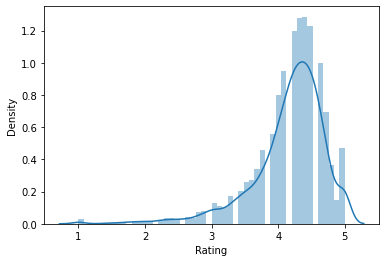

In [24]:
sns.distplot(df['Rating'])
print(np.mean(df['Rating']))

From the visualization, we can see that the data is skewed to the right, with there being significantly more values in the 4-5 range and the average being 4.16

### One Hot Encoding

We want to one hot encode the following variables

* **Category:** ART_AND_DESIGN, AUTO_AND_VEHICLES, BEAUTY, etc.
* **Installs:** 10,000+, 500,000+, 5,000,000+
* **Type:** Free, Paid
* **Content_Rating:** Everyone, Teen, Unrated, etc.
* **Genres:** Art_&_Design, Pretend_Play, Creativity, etc.
* **Last_Updated:** 2018, 2017, 2014, etc.

In [25]:
X.dtypes

Category           object
Reviews           float64
Size              float64
Installs          float64
Type               object
Price             float64
Content_Rating     object
Genres             object
Last_Updated       object
dtype: object

In [26]:
# One Hot Encoding of Category, Installs, Type, Content_Rating, Genres, and Last_Updated
X_encoded = pd.get_dummies(X, columns = ['Category',
                                         'Installs',
                                         'Type',
                                         'Content_Rating',
                                         'Genres',
                                         'Last_Updated'])
X_encoded.head()

,Reviews,Size,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,...,Genres_Word,Last_Updated_2010,Last_Updated_2011,Last_Updated_2012,Last_Updated_2013,Last_Updated_2014,Last_Updated_2015,Last_Updated_2016,Last_Updated_2017,Last_Updated_2018
0,159.0,19000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,967.0,14000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,87510.0,8700000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,215644.0,25000000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,967.0,2800000.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
y.dropna(inplace = True)
y
y.unique()

array([4.1, 3.9, 4.7, 4.5, 4.3, 4.4, 3.8, 4.2, 4.6, 3.2, 4. , 4.8, 4.9,
       3.6, 3.7, 3.3, 3.4, 3.5, 3.1, 5. , 2.6, 3. , 1.9, 2.5, 2.8, 2.7,
       1. , 2.9, 2.3, 2.2, 1.7, 2. , 1.8, 2.4, 1.6, 2.1, 1.4, 1.5, 1.2])

## Relationship Between Variables

First, we demonstrated the relationship between app ratings and the number of installs and reviews, as the number of installs and reviews are potential measures of an app's popularity, similar to ratings.

Text(0.5, 1.0, 'Relationship between App Rating and Installs')

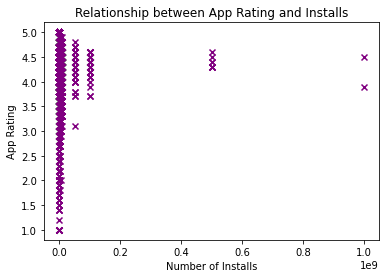

In [29]:
plt.scatter(df["Installs"], df["Rating"], marker='x', color="purple")
plt.xlabel("Number of Installs")
plt.ylabel("App Rating")
plt.title("Relationship between App Rating and Installs")

This graph shows the relationship between app ratings and the number of installs. There is no significant pattern in the graph, and there are outliers in this graph, as there are only a couple of data points that land in the 0.5 and 1.0 (times 10 to the power of 9) number of installs; most of the data points land between 0.0 and 0.2. Since the outliers affect the visualization or the data points, we decided to remove the outliers to have a better view of the graph.

Text(0.5, 1.0, 'Relationship between App Rating and Installs (Without Outliers)')

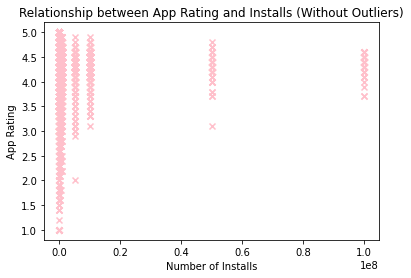

In [79]:
df_installsout = df.loc[df['Installs'].apply(lambda x: x < 0.2e9)]
plt.scatter(df_installsout["Installs"], df_installsout["Rating"], marker='x', color="pink")
plt.xlabel("Number of Installs")
plt.ylabel("App Rating")
plt.title("Relationship between App Rating and Installs (Without Outliers)")

After removing the outliers, there appears to be a very slight upward trend in the minimum threshold of app ratings as the number of installs increase. However, the trend is not significant enough for us to use this to train our data.

Text(0.5, 1.0, 'Relationship between App Rating and Reviews')

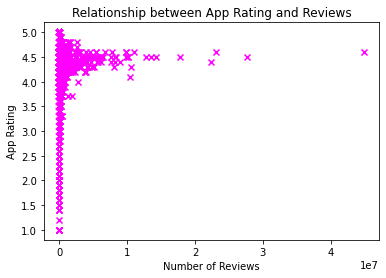

In [30]:
plt.scatter(df["Reviews"], df["Rating"], marker='x', color="magenta")
plt.xlabel("Number of Reviews")
plt.ylabel("App Rating")
plt.title("Relationship between App Rating and Reviews")

This graph shows the relationship between the app rating and the number of reviews. There appears to be a slight increase in the number of reviews as app ratings increase. Additionally, those with significantly large number of reviews all have high app ratings. Therefore, the number of reviews can be a potential candidate to help us train our models.

Next, we explored the relationship between app ratings and specific features of the apps, such as categories, pricing, content ratings, and last updated years.

In [31]:
df.groupby("Category").describe()["Rating"].sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
DATING,122.0,3.963934,0.665820,1.0,3.500,4.10,4.400,5.0
TOOLS,626.0,4.005911,0.640335,1.0,3.800,4.20,4.400,5.0
MAPS_AND_NAVIGATION,94.0,4.008511,0.561997,1.9,3.700,4.20,4.400,4.9
TRAVEL_AND_LOCAL,141.0,4.011348,0.571351,2.2,3.700,4.20,4.400,5.0
VIDEO_PLAYERS,112.0,4.021429,0.600815,1.8,3.700,4.20,4.400,4.9
COMMUNICATION,188.0,4.076596,0.523445,1.0,3.900,4.20,4.400,5.0
LIFESTYLE,269.0,4.089963,0.726222,1.5,3.800,4.20,4.600,5.0
BUSINESS,222.0,4.096396,0.688618,1.0,3.800,4.30,4.500,5.0
FINANCE,258.0,4.104651,0.694712,1.0,3.900,4.30,4.500,5.0


When listing all the categories out in order of average ratings, the 'dating' category appears to have the lowest average ratings, while the 'events' category appears to have the highest average ratings. However, since the number of ratings for each category (shown in the 'count' column in the table above) vary a lot, this could affect the ratings.

Text(0.5, 1.0, 'Relationship Between Price and Rating (Without Outliers)')

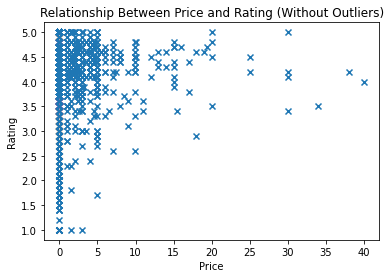

In [80]:
df_price = df.loc[df["Price"].apply(lambda x: x < 50)]
plt.scatter(df_price["Price"], df_price["Rating"], marker='x')
plt.xlabel("Price")
plt.ylabel("Rating")
plt.title("Relationship Between Price and Rating (Without Outliers)")

For the relationship between price and rating, we removed outliers and plotted a scatter plot. The plot shows that for the free (price = 0) apps, there is a wide range of ratings, but for paid ones (price > 0), there is an increase in rating as price goes up. Our proposed explanation for this is that when there is monetary value to apps, although there are exceptions, generally, the higher its price the higher its quality. Therefore, higher qualities usually result in higher ratings. On the other hand, when there is no monetary value to apps, the ratings of the app often depend on many other aspects, thus the ratings vary a lot.

Text(0.5, 1.0, 'Relationship Between Content Rating and Average App Rating')

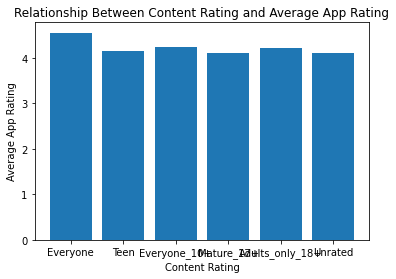

In [90]:
df_content_rating = df.groupby("Content_Rating").describe()
plt.bar(df["Content_Rating"].unique(), df_content_rating["Rating"]["mean"])
plt.xlabel("Content Rating")
plt.ylabel("Average App Rating")
plt.title("Relationship Between Content Rating and Average App Rating")

We used a bar graph to demonstrate the relationship between content rating and average app rating. The bar graph showed that there isn't a lot of difference between each content rating category as they all had an average rating of around 4~5. So, we decided to use a scatter plot to show the different average ratings in a larger scale.

Text(0.5, 1.0, 'Relationship Between Content Rating and Average App Rating')

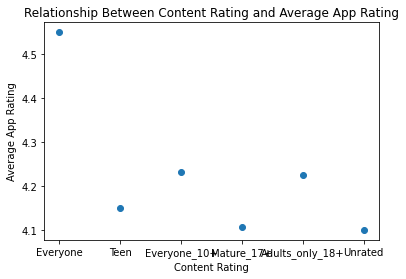

In [91]:
plt.scatter(df["Content_Rating"].unique(), df_content_rating["Rating"]["mean"], marker="o")
plt.xlabel("Content Rating")
plt.ylabel("Average App Rating")
plt.title("Relationship Between Content Rating and Average App Rating")

The scatter plot showed that although the average app ratings all landed between 4.1 and 5, apps for everyone had a significantly higher average rating than the other content rating categories. For this reason, we decided that content rating is a good factor that influences app ratings to some degree and can be used to help train our models.

Text(0.5, 1.0, 'Average Rating of Apps with Different Last Updated Years')

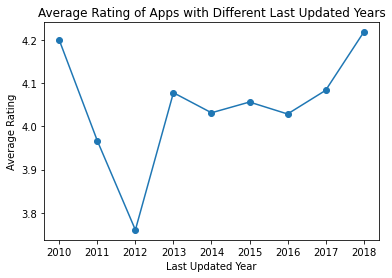

In [75]:
df_last_updated = df.groupby("Last_Updated").describe()
plt.plot(df_last_updated.index.values, df_last_updated["Rating"]["mean"], marker='o')
plt.xlabel("Last Updated Year")
plt.ylabel("Average Rating")
plt.title("Average Rating of Apps with Different Last Updated Years")

Here, the graph shows the average ratings of apps with different last-updated years, which is the year they were last updated in. Before 2012, there is a downward trend; however, after 2012, there is an upward trend. Our proposed explanation for why the graph may behave this way before 2012 is that 2010-2012 represents the beginning of app usage in mobile phones, thus 2010's average ratings were probably significantly higher than the other years because the new apps led to people's attractions and satisfactions with the progress made in mobile features, so apps made in those years have higher ratings. However, after 2012, the trend goes upward because the more updated an app is, the higher its quality will most likely be, which will lead to higher ratings. Given this, we think that "last updated year" is also a good factor that we can use to train our models.

In [67]:
df_rating = df.groupby("Rating").describe()
df_rating

Reviews                                                               \
         count           mean           std   min     25%     50%       75%   
Rating                                                                        
1.0       16.0       1.750000  1.125463e+00   1.0    1.00     1.0      2.00   
1.2        1.0      44.000000           NaN  44.0   44.00    44.0     44.00   
1.4        3.0      32.666667  1.250333e+01  20.0   26.50    33.0     39.00   
1.5        3.0      20.333333  3.175426e+01   2.0    2.00     2.0     29.50   
1.6        4.0     172.750000  1.847365e+02   8.0   31.25   140.5    282.00   
1.7        8.0     295.000000  4.293680e+02   6.0   13.00    52.5    446.75   
1.8        8.0     427.250000  1.148753e+03   5.0   10.25    21.5     35.75   
1.9       10.0     162.400000  2.833664e+02   8.0   27.75    73.5    132.00   
2.0       11.0     270.363636  6.550228e+02   1.0   10.00    24.0    171.50   
2.1        8.0     384.125000  8.133513e+02  14.0   70.25    86.5    169.75   
2.2       14.0     141.357143  2.625718e+02   4.0   19.00    32.0     77.75   
2.3       20.0     118.050000  2.067644e+02   3.0    7.50    32.0    111.25   
2.4       19.0     780.473684  2.668756e+03   7.0   34.00    99.0    314.00   
2.5       18.0     779.000000  1.391215e+03   2.0   21.00   185.5    759.00   
2.6       23.0     127.869565  1.722330e+02   5.0   13.00    64.0    154.00   
2.7       21.0     793.761905  1.434007e+03   3.0   17.00   135.0    560.00   
2.8       40.0    3118.250000  1.694282e+04   4.0   26.50    74.5    488.00   
2.9       43.0    1346.441860  4.892287e+03   7.0   43.00   118.0    392.50   
3.0       72.0    1339.986111  5.976305e+03   1.0    3.50    29.5    483.25   
3.1       62.0    4714.774194  1.273179e+04   7.0   82.25   305.5   1489.00   
3.2       59.0    3780.067797  1.339776e+04   4.0   42.00   190.0    810.00   
3.3       96.0   12065.541667  5.472847e+04   3.0   51.25   455.5   3059.25   
3.4      113.0    6154.433628  2.161892e+04   5.0   37.00   212.0   1999.00   
3.5      147.0    9469.217687  2.699925e+04   2.0   60.00   254.0   3781.50   
3.6      152.0    8005.605263  2.838895e+04   5.0   58.75   441.0   5349.50   
3.7      191.0   30991.240838  1.675973e+05   3.0   58.50   533.0   6036.50   
3.8      257.0   15773.957198  4.497679e+04   4.0   89.00   718.0   8226.00   
3.9      312.0   21008.996795  6.688496e+04   7.0  130.50  1226.0  10323.50   
4.0      449.0   36471.011136  1.546004e+05   1.0  154.00  1699.0  22435.00   
4.1      535.0   62701.497196  4.639685e+05   7.0  258.00  2903.0  29538.50   
4.2      672.0   99842.270833  3.414225e+05   4.0  327.25  5098.0  45309.75   
4.3      719.0  175252.895688  7.055633e+05   3.0  371.50  7287.0  54962.50   
4.4      723.0  275993.467497  1.177001e+06   5.0  377.50  7731.0  90014.50   
4.5      690.0  444137.002899  1.916172e+06   2.0  303.75  7928.5  80493.25   
4.6      563.0  356253.408526  2.341398e+06   5.0  222.00  5227.0  70154.00   
4.7      390.0   75950.571795  2.307531e+05   3.0   90.50  2237.0  31760.00   
4.8      205.0   74420.746341  2.767703e+05   4.0   18.00   238.0  17493.00   
4.9       84.0   12118.892857  4.037739e+04   7.0   25.75    77.5   1230.25   
5.0      266.0       8.428571  1.555867e+01   1.0    2.00     4.0      7.75   

                     Size                ...   Installs                Price  \
               max  count          mean  ...        75%           max  count   
Rating                                   ...                                   
1.0            5.0   16.0  1.430000e+07  ...      500.0  1.000000e+03   16.0   
1.2           44.0    1.0  2.700000e+07  ...     1000.0  1.000000e+03    1.0   
1.4           45.0    3.0  6.733333e+06  ...     3000.0  5.000000e+03    3.0   
1.5           57.0    3.0  1.800000e+07  ...      550.0  1.000000e+03    3.0   
1.6          402.0    4.0  1.615000e+07  ...    62500.0  1.000000e+05    4.0   
1.7         1172.0    8.0  1.003750e+07  ...    

In [34]:
df_rating.loc[5.0]

Reviews   count    2.660000e+02
          mean     8.428571e+00
          std      1.555867e+01
          min      1.000000e+00
          25%      2.000000e+00
          50%      4.000000e+00
          75%      7.750000e+00
          max      1.410000e+02
Size      count    2.660000e+02
          mean     1.409606e+07
          std      1.738528e+07
          min      5.500000e+04
          25%      3.225000e+06
          50%      7.450000e+06
          75%      1.900000e+07
          max      9.600000e+07
Installs  count    2.660000e+02
          mean     3.241090e+02
          std      8.461957e+02
          min      1.000000e+00
          25%      5.000000e+01
          50%      1.000000e+02
          75%      1.000000e+02
          max      1.000000e+04
Price     count    2.660000e+02
          mean     3.835714e-01
          std      2.307470e+00
          min      0.000000e+00
          25%      0.000000e+00
          50%      0.000000e+00
          75%      0.000000e+00
        

Apps with full 5.0 ratings have the above quantitative data on their reviews, size, number of installs, and price. We can see that ......

## OLS

We are going to begin by fitting the data to an Ordinary Least Squares regression to get a baseline for performance. We know that the Average Rating is a 4.16 in the dataset. We can split accordingly.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.25, random_state = 10)

In [36]:
OLS = LinearRegression()
OLS.fit(X_train, y_train)

LinearRegression()

In [37]:
# Intercept/Coefficients for OLS
print(OLS.intercept_)
print(OLS.coef_)
print(OLS.score(X_train, y_train))

4.32729193703548
[ 1.76414659e-08 -3.41527991e-10 -8.94398781e-04  1.05734677e-01
 -1.82159879e-02  5.85851417e-02  1.16997165e-01 -2.73155738e-02
  4.09668605e-03 -7.06313652e-02 -1.03973781e-01  4.84155175e-02
 -1.41263239e-02  1.72343257e-01  3.46405279e-02  1.01314481e-03
 -6.59866107e-02  1.23131733e-01  3.54674409e-03 -1.97734493e-02
  4.89540813e-02 -1.34726599e-01 -8.29278564e-02 -1.01303734e-02
 -2.72558242e-02 -2.01432480e-02  5.98289768e-02 -4.74876332e-02
 -2.37560879e-02  1.13852468e-02  2.10873370e-02  2.39661194e-02
 -7.06044286e-02 -7.93080393e-02 -5.12315801e-02  3.38684057e-02
  6.50323845e-01  6.61416917e-01  2.22569045e-01  1.28218754e-01
  1.20278572e-01 -1.01036591e-01 -2.17767045e-01 -2.39895370e-01
 -2.41613510e-01 -2.20319259e-01 -1.57049317e-01 -1.12184433e-01
 -5.56369209e-02 -6.48964829e-02  2.23351830e-02  2.83915670e-02
 -5.32024296e-03 -2.50873126e-02 -3.92727400e-01 -6.41705084e-02
  6.41705082e-02  2.21171867e-01 -6.59750761e-02 -3.53837663e-02
 -8.5351

In [38]:
y_pred = OLS.predict(X_test)
performance = pd.DataFrame({'Predictions:': y_pred, 'Actual Values:': y_test})
performance['Error'] = performance['Actual Values:'] - performance['Predictions:']
performance.head()

,Predictions:,Actual Values:,Error
706,4.378577,4.7,0.321423
2683,4.404920,4.3,-0.104920
9633,4.483443,4.0,-0.483443
4704,4.217667,4.3,0.082333
425,3.952402,4.1,0.147598


In [39]:
performance.reset_index(drop=True, inplace=True)
performance.reset_index(inplace=True)
performance.head()

,index,Predictions:,Actual Values:,Error
0,0,4.378577,4.7,0.321423
1,1,4.404920,4.3,-0.104920
2,2,4.483443,4.0,-0.483443
3,3,4.217667,4.3,0.082333
4,4,3.952402,4.1,0.147598


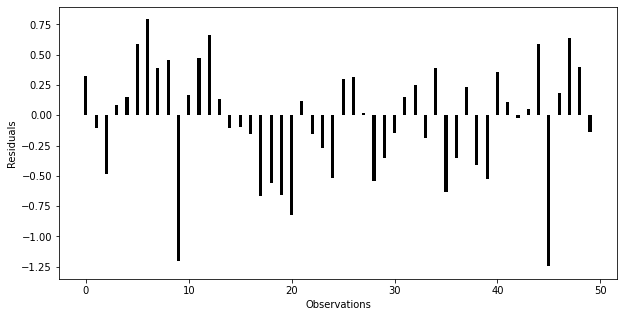

In [40]:
fig = plt.figure(figsize=(10,5))
plt.bar('index', 'Error', data=performance[:50], color = 'black', width = 0.3)
plt.xlabel('Observations')
plt.ylabel('Residuals')
plt.show()

In [41]:
X_train = sm.add_constant(X_train)
nicerOLS = sm.OLS(y_train, X_train).fit()
nicerOLS.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.482
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           2.73e-59
Time:                        11:45:57   Log-Likelihood:                -4112.3
No. Observations:                5270   AIC:                             8513.
Df Residuals:                    5126   BIC:                             9459.
Df Model:                         143                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            2.2593      0.058     39.100      0.000       2.146       2.373
Reviews                                       1.764e-08    9.3e-09      1.898      0.058   -5.82e-10    3.59e-08
Size                                         -3.415e-10   4.12e-10     -0.829      0.407   -1.15e-09    4.66e-10
Price                                           -0.0009      0.000     -2.128      0.033      -0.002   -7.05e-05
Category_ART_AND_DESIGN                          0.1931      0.160      1.204      0.229      -0.121       0.508
Category_AUTO_AND_VEHICLES                       0.0400      0.040      0.997      0.319      -0.039       0.119
Category_BEAUTY                                  0.1168      0.050      2.332      0.020       0.019       0.215
Category_BOOKS_AND_REFERENCE                     0.1753      0.028      6.251      0.000       0.120       0.230
Category_BUSINESS                                0.0309      0.024      1.288      0.198      -0.016       0.078
Category_COMICS                                  0.0624      0.046      1.345      0.179      -0.029       0.153
Category_COMMUNICATION                          -0.0124      0.025     -0.486      0.627      -0.062       0.038
Category_DATING                                 -0.0457      0.036     -1.265      0.206      -0.117       0.025
Category_EDUCATION                               0.1574      0.082      1.927      0.054      -0.003       0.317
Category_ENTERTAINMENT                           0.0948      0.091      1.048      0.295      -0.083       0.272
Category_EVENTS                                  0.2306      0.050      4.590      0.000       0.132       0.329
Category_FAMILY                                  0.1436      0.045      3.197      0.001       0.056       0.232
Category_FINANCE                                 0.0593      0.023      2.628      0.009       0.015       0.103
Category_FOOD_AND_DRINK                         -0.0077      0.039     -0.197      0.844      -0.085       0.069
Category_GAME                                    0.2321      0.072      3.239      0.001       0.092       0.373
Category_HEALTH_AND_FITNESS                      0.0618      0.025      2.447      0.014       0.012       0.111
Category_HOUSE_AND_HOME                          0.0385      0.051      0.756      0.450      -0.061       0.138
Category_LIBRARIES_AND_DEMO                      0.1072      0.042      2.557      0.011       0.025       0.189
Category_LIFESTYLE                              -0.0571      0.174     -0.328      0.743      -0.398       0.284
Category_MAPS_AND_NAVIGATION                    -0.0247      0.033     -0.739      0.460      -0.090       0.041
Category_MEDICAL                

## Preliminary XGBoost Model

Now, lets verify that the average in our training and testing data is close to that of the entire dataset to ensure an even split in training and testing data.

In [42]:
sum(y_train)/len(y_train)

4.158102466793159

In [43]:
sum(y_test)/len(y_test)

4.168184405236192

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.25, random_state = 10)

In [45]:
xgb_r = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 100, seed = 42, silent = True)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)

In [46]:
#Scoring by root mean square error (rmse)
rmse = np.sqrt(MSE(y_test, pred))
print('RMSE: % f' %(rmse))

RMSE:  0.526272


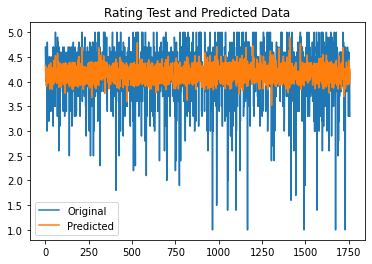

In [47]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label = 'Original')
plt.plot(x_ax, pred, label = 'Predicted')
plt.title("Rating Test and Predicted Data")
plt.legend()
plt.show()

Our model appears to be predicted values very close to the mean, having a hard time dealing with values far from the mean.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


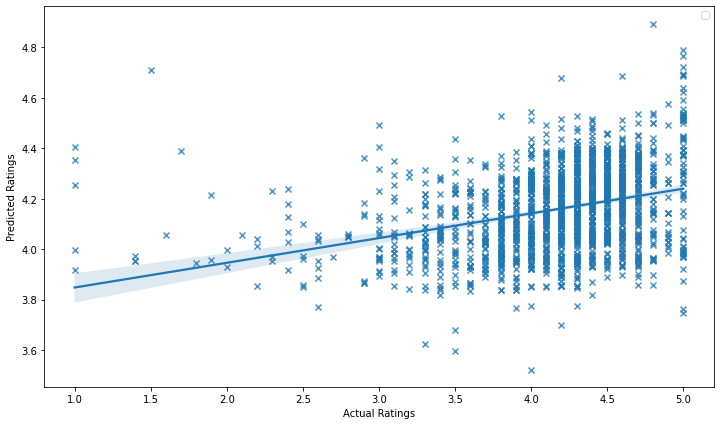

In [48]:
plt.figure(figsize=(12,7))
sns.regplot(y_test,pred, marker = 'x')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()

## Optimizing Parameters for Better XGBoost Model

In [49]:
param_grid = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 500]
              }

In [50]:
xgb_grid = GridSearchCV(xgb_r,
                        param_grid,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [51]:
#takes some time to run
xgb_grid.fit(X_train,
         y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


GridSearchCV(cv=2, estimator=XGBRegressor(seed=42, silent=True), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [100, 500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [52]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.0867522376592178
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


##**Output:** <br> 
0.0867522376592178 <br>
{'colsample_bytree': 0.7,<br> 'learning_rate': 0.05,<br> 'max_depth': 7, <br>'min_child_weight': 4, <br>'n_estimators': 100, <br>'nthread': 4,<br>'objective': 'reg:linear',<br> 'silent': 1,<br> 'subsample': 0.7}

Update params based on values they are leaning towards for a secondary gridsearch

In [53]:
param_grid = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.01,.02,.03], 
              'max_depth': [3,4,5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
              }
xgb_grid = GridSearchCV(xgb_r,
                        param_grid,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [54]:
xgb_grid.fit(X_train,
         y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=XGBRegressor(seed=42, silent=True), n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [3, 4, 5], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [55]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


0.08402358622056572
{'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


##**Output:** <br> 
0.08402358622056572 <br>
{'colsample_bytree': 0.7,<br> 'learning_rate': 0.02, <br> 'max_depth': 4, <br>'min_child_weight': 4, <br> 'n_estimators': 500, <br>'nthread': 4, <br>'objective': 'reg:linear',<br> 'silent': 1,<br> 'subsample': 0.7}

In [56]:
xgb_r = xgb.XGBRegressor(colsample_bytree = 0.7, 
                         learning_rate = 0.02,
                         max_depth = 4, 
                         min_child_weight = 4,
                         n_estimators = 500,
                         nthread = 4,
                         objective = 'reg:linear',
                         silent = 1,
                         subsample = 0.7)

In [57]:
print("Lowest MSE found: ", np.abs(xgb_grid.best_score_))


Lowest MSE found:  0.08402358622056572


In [58]:
xgb_r.fit(X_train, y_train, verbose= False, early_stopping_rounds = 20, eval_set = [(X_test,y_test)])
pred = xgb_r.predict(X_test)

Our new RMSE is 0.5187 in comparison to our initial RMSE of  0.5262, showing a slight improvement after performing our gridsearch for hyperparameter optimization.

In [59]:
#TODO Random Forest Regressor

In [60]:
#from scipy.stats import boxcox
#bcx_target, lam =boxcox(df['Rating'])
#xgb_model = xgb.XGBRegressor(random_state = 42)
#xgb_model.fit(X_train, y_train)

In [61]:
#y_xgpred = xgb_model.predict(X_test)
#mse = mean_squared_error(inv_boxcox(y_test,lam), inv_boxcox(y_xgpred,lam))
#print('Mean Squared Error:',mse)

##SVM

In [62]:
svm = svm.SVR()
svm.fit(X_train, y_train)
svm_results = svm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


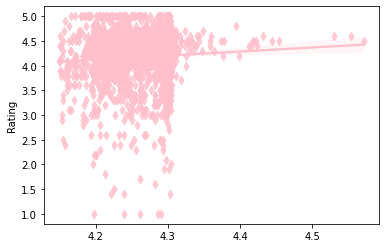

In [63]:
sns.regplot(svm_results, y_test, color='pink', label='SVM', marker='d')

# Proposed Solution

The solution we will be implementing to reach our goal is using Ordinary Least Squares and linear regression, then using XGBoost and cross validation. In order to implement this we will have to follow distinct steps, including creating a weight vector, in which we would have to calculate the optimum w that yields the minimum loss and taking the gradient. Something that will help us analyze the code is one-hot encoding, where we will have to transform categorical data to numerical to allow further analysis. After completing this, with other types of wrangling, we will implement linear regression creating a function that follows the mathematical computation. Some function calls that we will be implementing are numpy, pandas, seaborn, sklearn to compare different features that affect app ratings to ultimately see what variable has the highest correlation. Other than OLS and linear regression, we will implement gradient boosted decision trees using XGBoost and compare models using cross validation.

# Evaluation Metrics

Since we are planning on using a regression model to predict app ratings from different features, one of the evaluation metrics we'll probably be using is the mean square error to determine the goodness of fit. Mean square error is calculated by the sum of the square of prediction error (expected output minus predicted output) divided by the number of data points, suggesting how far off our rating predictions are from the actual expected results. Another potential metric is using the mean absolute error, which is the same as mean square error except it takes the absolute value of prediction error instead of the square, to determine how far off our predictions are if we treat all errors the same. Mean square error will penalize big rating prediction errors more due to the square, but both metrics may be potential ways we could use to identify how good of a fit our model is.




# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for? 
### Ethics & Privacy

It is important for us to gather accurate data by checking its accuracy and reliability. It is also important for us to make sure that the data can be acquired by the public and is permitted by the owner. We need to be neutral about the evaluations and rely on evidence instead of assumptions. As for people's reviews on the apps, we should keep them anonymous in order to protect their privacies. A tool that can help us address these potential issues is https://deon.drivendata.org.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="1">1</a>: Houd, Anass El (19 Sept 2020) DS Project: How to Predict Google Apps Rating? *Towards Data Science*. https://towardsdatascience.com/ds-project-how-to-predict-google-apps-rating-618ebc77cad<br> 
<a name="2">2</a>: Lutkevich, Ben (Mar 2021) What is Natural Language Processing? An Introduction to NLP *Tech Target*. https://www.techtarget.com/searchenterpriseai/definition/natural-language-processing-NLP#:~:text=Natural%20language%20processing%20(NLP)%20is,in%20the%20field%20of%20linguistics<br>
<a name="3">3</a>: Pandey, Pranjal (7 Sept 2021) Machine Learning: Linear Regression and its applications *The Data Science Portal*. https://thedatascienceportal.com/posts/linear-regression-and-its-applications